<a href="https://colab.research.google.com/github/alexjameswilliams/Music-Text-To-Image-Generation/blob/main/Sound_and_Image_informed_Music_Artwork_Generation_Using_Text_to_Image_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook presents a pipeline for the generation of music artwork that is informed by contextual semantic tags of audio and visual works, and shaped by user prompt engineering.

**This work was submitted in:**

*Alexander Williams, Stefan Lattner, and Mathieu Barthet. 2023. Sound-and-
Image-informed Music Artwork Generation Using Text-to-Image Models.
In MuRS: Music Recommender Systems Workshop, September 18–22, 2023,
Singapore. ACM, New York, NY, USA*

![picture](https://drive.google.com/uc?export=view&id=1IXukrpsMCkTVasuhHQHFdoEumNbDFz3D)

This is achieved via the incorporation of a series of deep learning models for image captioning, music tagging, and image generation.
We also include a simple music generation system to generate sample collages for use in a music production context, to demonstrate how artwork generation is affected by different musical pieces.

To demonstrate how our system may be used, we present an example generation process using artwork and sounds from the Gloo collective.

Gloo is a musical collective with a unique visual and sonic identity, comprised of the artists Iglooghost, Babii, and Kai Whiston, who create music and artwork collaboratively and independently.
Gloo’s diverse sound incorporates elements of grime, synth-pop, IDM, and bass, among other genres.
Part of these artists' creative process is to compose their music through the synthesis and manipulation of audio samples, with each artist having also released their own commercial sample pack for royalty-free use by other music producers.
Iglooghost has stated that when composing music they first create an image and then set themselves the challenge of making a song to fit the image, demonstrating the extent to which sonic and visual elements in Gloo’s output are linked.

For this reason we have chosen to demo our system on these visual and sonic materials but the system presented is general enough that alternative audio / image datasets are easily substituted.

![picture](https://drive.google.com/uc?export=view&id=1ni6lQOH6lwHZyFcxNEwIWiB1aGYurRAk)

The generation process is as follows:
A dataset is compiled of 23 album artworks from releases on Gloo whereby text descriptions of a user-defined number of characters are generated for each image in this dataset using the CLIP Interrogator Models. All delimited textual descriptions were compiled together into a set of descriptors for Gloo artwork.

A second dataset is compiled from the three sample packs released by Iglooghost, Babii, and Kai Whiston respectively with a combined total of 414 short audio samples of typically less than ten seconds in length with a variety of sound types across one-shots, loops, synths, percussion, vocals, FX and more. 5 random samples from the sample packs are loaded randomly into an inline GUI step sequencer in the colab notebook built in an interactive ipywidget on top of the wubwub step sequencer library. No specialised generative algorithm is used for sample arrangement besides random, bounded parametrisations. Instead, users are invited to tweak the existing parametrisation, or randomly generate new combinations to explore sound collages with control over a number of parameters including timing signatures, length, tempo, volume, panning, and sample selection offered via a GUI.

Once a musical composition has been finalised by the user, it is analysed by the MusiCNN to extract a list of music tags. The most relevant tags to the piece of music are identified and kept. An algorithm then randomly selects user-defined number prompts from the image-to-text description generation on the Gloo artwork, and another user-defined number of prompts from the MusiCNN tags on the specific piece to collate a full list of descriptive prompts.
Finally, this set of prompts is fed into the Stable Diffusion text-to-image generation model and a generative image is produced. The user additionally has the option to add their own additional prompts to steer the generation if desired. Thus, this process produces a short composition of arranged electronic music samples, along with an image that is inspired by the music, and the aesthetics of the Gloo collective.

![picture](https://drive.google.com/uc?export=view&id=1IZojb-uQlYz05hRMyAOEaKqmot2mpLHo)


# Setup / Installations

In [ ]:
#@title General Imports
import os, subprocess, csv, random, sys
from IPython.display import clear_output, display, Audio
import ipywidgets as widgets

from PIL import Image
from os import listdir
from os.path import isfile, join
from pathlib import Path

import numpy ####
import scipy####maybe get rid
from random import randrange
!pip install librosa
import librosa

clear_output()

In [ ]:
#@title Mount Google Drive / Assign Directories
from google.colab import drive
drive.mount('/content/drive/')

IMAGE_DIR = '/content/drive/MyDrive/GLOO_SAMPLES/IMAGES' #@param
AUDIO_DIR = '/content/drive/MyDrive/GLOO_SAMPLES/unsorted'#@param
IMAGE_DESCRIPTION_PATH = '/content/drive/MyDrive/GLOO_SAMPLES/IMAGES/desc.csv'#@param
SAVE_DIR = "/content/drive/MyDrive/GLOO_SAMPLES/all_generated_outputs"#@param
most_recent_save_path = ''

from os import listdir

file_names = os.listdir(AUDIO_DIR)
print(file_names[:10])
# Add all sample files in directory to list
#file_names = [f for f in listdir(AUDIO_DIR) if isfile(join(AUDIO_DIR, f))]

Mounted at /content/drive/
['BABii_BOUNCY_808_SYNTH_C.wav', 'BABii_TIMP_DELAY_SYNTH_A.wav', 'BABii_SEIZURE_BELL_SYNTH_C.wav', 'BABii_KILLER_WIDE_BASS_C.wav', 'BABii_CRiiSPYHOWL_VOCAL_Em.wav', 'BABii_A_HORRiiBLE_BELL_SYNTH_C.wav', 'BABii_PiiNG_SYNTH_C.wav', 'BABii_CRUNCH_ECHO_HA_VOCAL_LOOP_125_Em.wav', 'BABii_GATED_KAI_YELL_VOCAL_LOOP_125_Em.wav', 'BABii_HEHEHAHA_VOCAL_LOOP_100_Bbmin.wav']


In [ ]:
#@title Clip Interrogator Image Tagging Imports
def setup():
    install_cmds = [
        ['pip', 'install', 'open_clip_torch'],
        ['pip', 'install', 'clip-interrogator'],
    ]
    for cmd in install_cmds:
        print(subprocess.run(cmd, stdout=subprocess.PIPE).stdout.decode('utf-8'))

#display.Javascript
setup()

from clip_interrogator import Config, Interrogator
from tqdm import tqdm
clear_output()

In [ ]:
#@title Download WubWub Music Sequencer Library
!git clone https://github.com/earnestt1234/wubwub
clear_output()

In [ ]:
#@title Install Packages for Music Sequencer Libary
!pip3 install 'pydub>=0.25'
!pip install pysndfx
!pip install 'gdown>=4.5'
!pip install 'numpy>=1.21'
!pip install 'sortedcontainers>=2.4'
!pip install 'simpleaudio>=1.0.4'
!pip install sox
clear_output()

In [ ]:
#@title Music Sequencer Libary Setup
%cd /content
!python /content/wubwub/setup.py build
!python /content/wubwub/setup.py install --user
sys.path.append('/content/wubwub')

import wubwub as wb

# Music Sequencer Libary Imports

from wubwub.audio import *
from wubwub.errors import *
from wubwub.notes import *
from wubwub.pattern import *
from wubwub.pitch import *
from wubwub.plots import *
from wubwub.resources import *
from wubwub.seqstring import *
from wubwub.sequencer import *
from wubwub.sounds import *
from wubwub.tracks import *

clear_output()

In [ ]:
#@title Import MusiCNN for Music Tagging
#@markdown Note:
#@markdown Importing of this module can be temperamental in Colab due to current supported Python versions.
#@markdown Python 3.7 Required

# Needed to avoid an encoding bug
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Music Tagging Imports

try:
  !pip install musicnn
  from musicnn.extractor import extractor
  clear_output()
except:
  clear_output()
  print("Failed to Import MusiCNN")


Failed to Import MusiCNN


In [ ]:
#@title Stable Diffusion Image Generation Setup
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

import torch
from diffusers import StableDiffusionPipeline

#@ #Setup the Diffusers Stable Diffusion Pipeline

device = "cuda"
model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe = pipe.to("cuda")
clear_output()

# Generate Image Description with Clip Interrogator

In [ ]:
#@title Setup
#@markdown select CLIP Interrogator models
caption_model_name = 'blip-large' #@param ["blip-base", "blip-large", "git-large-coco"]
clip_model_name = 'ViT-L-14/openai' #@param ["ViT-L-14/openai", "ViT-H-14/laion2b_s32b_b79k"]

config = Config()
config.clip_model_name = clip_model_name
config.caption_model_name = caption_model_name
ci = Interrogator(config)

def image_analysis(image):
    image = image.convert('RGB')
    image_features = ci.image_to_features(image)

    top_mediums = ci.mediums.rank(image_features, 5)
    top_artists = ci.artists.rank(image_features, 5)
    top_movements = ci.movements.rank(image_features, 5)
    top_trendings = ci.trendings.rank(image_features, 5)
    top_flavors = ci.flavors.rank(image_features, 5)

    medium_ranks = {medium: sim for medium, sim in zip(top_mediums, ci.similarities(image_features, top_mediums))}
    artist_ranks = {artist: sim for artist, sim in zip(top_artists, ci.similarities(image_features, top_artists))}
    movement_ranks = {movement: sim for movement, sim in zip(top_movements, ci.similarities(image_features, top_movements))}
    trending_ranks = {trending: sim for trending, sim in zip(top_trendings, ci.similarities(image_features, top_trendings))}
    flavor_ranks = {flavor: sim for flavor, sim in zip(top_flavors, ci.similarities(image_features, top_flavors))}

    return medium_ranks, artist_ranks, movement_ranks, trending_ranks, flavor_ranks

def image_to_prompt(image, mode):
    ci.config.chunk_size = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    ci.config.flavor_intermediate_count = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    image = image.convert('RGB')
    if mode == 'best':
        return ci.interrogate(image)
    elif mode == 'classic':
        return ci.interrogate_classic(image)
    elif mode == 'fast':
        return ci.interrogate_fast(image)
    elif mode == 'negative':
        return ci.interrogate_negative(image)

clear_output()

Generating prompts:   0%|          | 0/23 [00:00<?, ?it/s]

there are many different characters in this picture together, music album art, wearing a witch hat, transparent goo, by Nōami, ghost in the machine, ice spell, bog, by Muqi, in an igloo, irridescent ghostly, ghostly, ios, alternate album cover, blingee


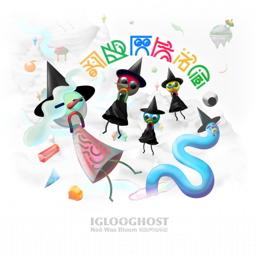

Generating prompts:   4%|▍         | 1/23 [01:05<23:58, 65.38s/it]

cartoon character of a woman with a red cape and a black shirt, noise rock album cover, onmyoji, no face, very very very very electronic, hints of yayoi kasuma, noot noot, the caretaker, videogame cover art, miro, aka dream, many doors, vocalist, wrapped arms


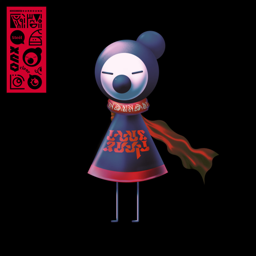

Generating prompts:   9%|▊         | 2/23 [01:49<18:33, 53.02s/it]

there is a cartoon clown with a party hat and a dress, arca album cover, kawaii hq render, albino mystic, ps2, png, very very very very electronic, fantasy boss, nico tanigawa, what music they make, wizard man, a friendly wisp


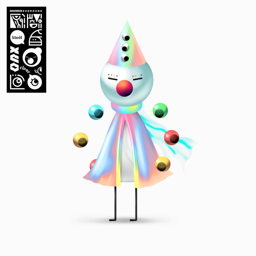

Generating prompts:  13%|█▎        | 3/23 [02:28<15:33, 46.68s/it]

there is a picture of a flower with many colors and shapes, bladee from drain gang, post - punk new age album cover, persian design, template layout, floating runes, 2009, lossless, hebrew, white body, forbidden beauty, app icon, lotus, unreal 6, floating symbols


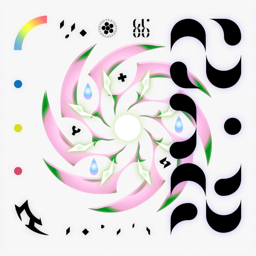

Generating prompts:  17%|█▋        | 4/23 [03:17<15:03, 47.55s/it]

there is a black background with a colorful design and a white background, official artwork, with glow on some of its parts, infinite in extent, inspired by Ahmed Karahisari, holo sticker, ornate complexity, computer glitch, by Mac Conner, arabic calligraphy, other dimensions, discord emoji


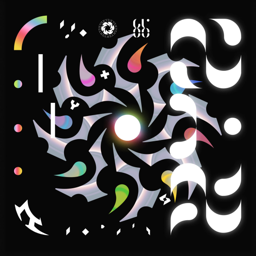

Generating prompts:  22%|██▏       | 5/23 [03:56<13:19, 44.39s/it]

a close up of a black background with a yellow and black text, vektroid album cover, ak 1 2, by Asai Chū, unity 2 d, studio ghibli and pixar and abzu, mewtwo, zig zag, doja cat, features between french, by Muqi, cat on a windowsill, 1128x191 resolution


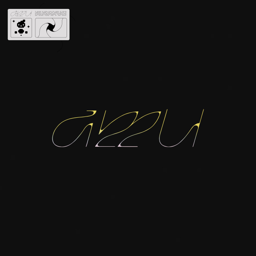

Generating prompts:  26%|██▌       | 6/23 [04:37<12:17, 43.36s/it]

there is a drawing of a bunny with a lot of different things, ethereal eel, album art for char zulu, floating waterfalls, ethereal ghostly atmosphere, tamagotchi, 2 0 0 0 s cover art, inspired by Sōami, by Chippy, lab, full art, idillic, 2012, bjork, cover


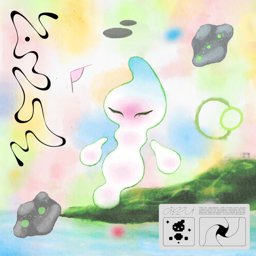

Generating prompts:  30%|███       | 7/23 [05:28<12:13, 45.83s/it]

there is a poster with a picture of a person in a space suit, colourful biomorphic temple, by Wolfgang Zelmer, cd cover artwork, inspired by Hidari Jingorō, runic inscription, lossless, pale yellow sky, iridescent and opalescent, weirdcore, pale-skinned


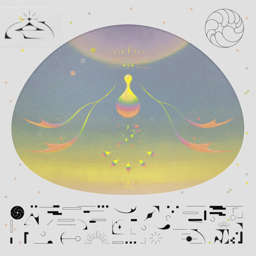

Generating prompts:  35%|███▍      | 8/23 [06:06<10:49, 43.31s/it]

there are two clocks on the wall with different designs on them, zen méditation cyberpunk, transparent marble butterfly, inspired by Alfonse Mucha, yellow volumetric fog, ██full of expressions██, gold mask, opal petals, uncompressed png, inspired by Sesshū Tōyō, bjork aesthetic, new design


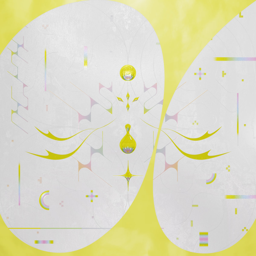

Generating prompts:  39%|███▉      | 9/23 [06:49<10:02, 43.04s/it]

there is a metal plaque with a cross and a cross on it, ray tracing global illumination, bladee from drain gang, post - punk new age album cover, translucent stone white skin, generative design, --n 6, inspired by Henri Alphonse Barnoin, library of babel, ue6, - n 6, by Erwin Bowien


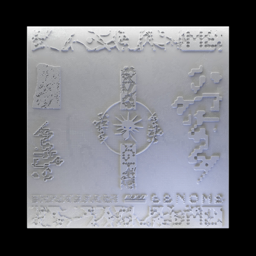

Generating prompts:  43%|████▎     | 10/23 [07:27<09:02, 41.72s/it]

there is a pink background with a cartoon face and a teapot, various eye shapes, ios, seapunk, jonathan zawada, worried, monsters in the background, movie texture, sensors, black spot over left eye, app, treasure on walls, snake eyes, exploitable image, goop


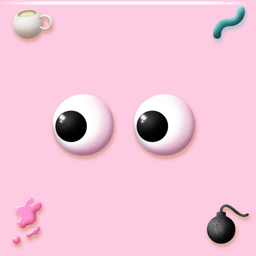

Generating prompts:  48%|████▊     | 11/23 [08:18<08:51, 44.32s/it]

there is a cartoon image of a bird with a watermelon and a banana, phonk album cover, moonlit forest environment, six eyes, eyes shone bright in the night, version 3, eyeless, 2 0 1 2 watermelon diner, color degragation, alternate album cover, campsites, lonesome


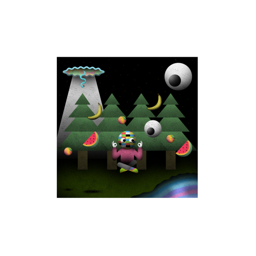

Generating prompts:  52%|█████▏    | 12/23 [08:56<07:46, 42.44s/it]

there is a picture of a pink poster with a picture of a nui, new age album cover, by Lü Ji, uppercase letter, multiple eyes, inspired by Niko Henrichon, luigi's nose, colorfully ominous background, 1 : 1 album artwork, nut, humanisation, toon aesthetic, vulcano, prerendered isometric graphics, by Okuda Gensō


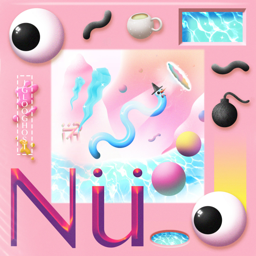

Generating prompts:  57%|█████▋    | 13/23 [09:44<07:20, 44.06s/it]

brightly colored cartoon character with a hat and a colorful dress, chawick the fail wizard, ios emoji, by Ai Weiwei, an ominous fantasy illustration, designed in blender, gryffindor, 2 0 1 9, twitter pfp, witches, he is sad, cyber aesthetic, by Taro Okamoto, hyperrealstic, wicca


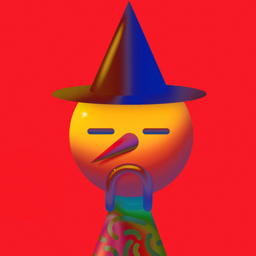

Generating prompts:  61%|██████    | 14/23 [10:32<06:47, 45.31s/it]

there is a black sculpture of a woman holding a flower, blue color bleed, arabic calligraphy, android body, - signature, test, inspired by Wifredo Lam, aspect ratio 1:3, by John Souch, loosely cropped, techno artwork, spire, smooth metal, arabian calligraphy, inspired by Henri Alphonse Barnoin


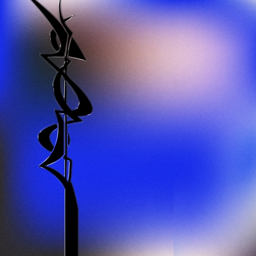

Generating prompts:  65%|██████▌   | 15/23 [11:20<06:09, 46.19s/it]

there is a glass sculpture with a star on top of it, metamorphosis complex 3d render, golden and silver jewerly, disconnected shapes, playstation 2 screenshot, mugler, wolff olins |, uncompressed png, detailed decorative flourishes, biomechanical gaia, autechre


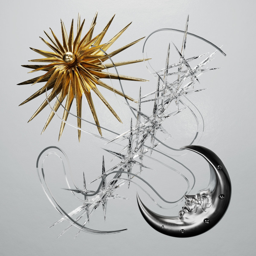

Generating prompts:  70%|██████▉   | 16/23 [11:55<04:59, 42.78s/it]

a close up of a black background with a flower and a star, video game genshin impact, noise rock album cover, beaming shining light, by Ayshia Taşkın, shiny gems, tatooine, discogs, albino skin, inspired by Antonín Chittussi, rating: general, god - rays, 7 0 - s, pv


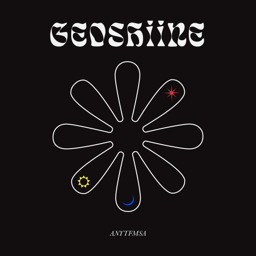

Generating prompts:  74%|███████▍  | 17/23 [12:43<04:25, 44.27s/it]

there is a cd with a picture of a moon and a star, (aesthetics), basil, eboy, glowing white face, limited edition print, official product image, bereal, scarab, insibidi symbols, opal, offset, silver palette, bear, minimal design


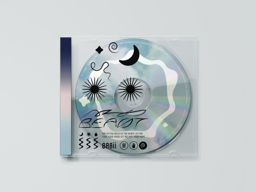

Generating prompts:  78%|███████▊  | 18/23 [13:31<03:47, 45.45s/it]

there is a black and white drawing of a cat and a snowflake, juno promotional image, arabic pronunciation: [kaʕ.bah]), fragmented typography, reindeer made out of shadows, rounded logo, linda wilder, unlife, nitid horizon, tsuruda


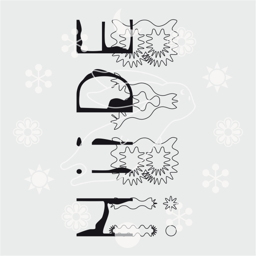

Generating prompts:  83%|████████▎ | 19/23 [14:06<02:49, 42.45s/it]

there is a black background with a bunch of metal spikes, inspired by Jang Seung-eop, luxury hd render, yeezus, isolate, cl, 4l, inspired by Marina Abramović, kardur\'s vicious return, pillar, negative energy, necro, star, painful vibe, icon


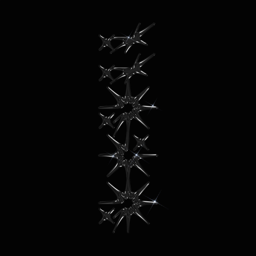

Generating prompts:  87%|████████▋ | 20/23 [14:57<02:14, 44.80s/it]

there is a picture of a yellow flower with white and yellow flowers, minimalist illustration, aspect ratio 1:3, daffodils, inspired by William Forsyth, discarded scrolls, photodirector 3 6 5, diffuse sunlight, long thick grass, inspired by Annabel Kidston, ai - generated art, full width, null


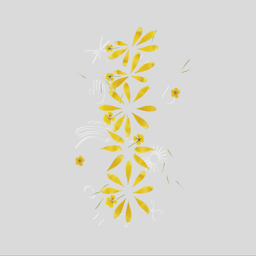

Generating prompts:  91%|█████████▏| 21/23 [15:38<01:27, 43.73s/it]

there is a black and white poster with a four leaf clover, by Sophie Taeuber-Arp, kewpie, phonk album cover, farscape, with sleek lines and a powerful, material pack, inspired by Sadao Watanabe, idillic, diaper-shaped, barbarella, sci fi font, sacred numbers, vlop, bag


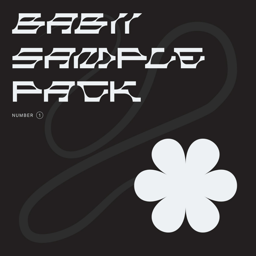

Generating prompts:  96%|█████████▌| 22/23 [16:25<00:44, 44.87s/it]

there is a glass sculpture of a woman with a flower in her hair, particle sim, grey skinned, photo of a hand jewellery model, interconnected human lifeforms, white: 0.5, surface scattering, snowflakes, digital screenshot, wearing transparent glass mask, inspired by Johanna Marie Fosie, gloss


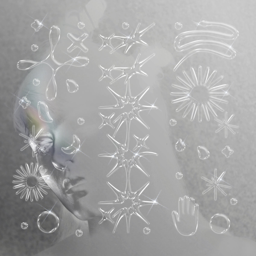

Generating prompts: 100%|██████████| 23/23 [17:04<00:00, 44.55s/it]






Generated 23 prompts and saved to /content/drive/MyDrive/GLOO_SAMPLES/IMAGES/desc.csv, enjoy!


In [ ]:
#@title Batch process a folder of images 📁 -> 📝

#@markdown This will generate prompts for every image in a folder and either save results
#@markdown to a desc.csv file in the same folder or rename the files to contain their prompts.
#@markdown The renamed files work well for [DreamBooth extension](https://github.com/d8ahazard/sd_dreambooth_extension)
#@markdown in the [Stable Diffusion Web UI](https://github.com/AUTOMATIC1111/stable-diffusion-webui).
#@markdown You can use the generated csv in the [Stable Diffusion Finetuning](https://colab.research.google.com/drive/1vrh_MUSaAMaC5tsLWDxkFILKJ790Z4Bl?usp=sharing)

folder_path = IMAGE_DIR #@param {type:"string"}
prompt_mode = 'best' #@param ["best","fast","classic","negative"]
output_mode = 'desc.csv' #@param ["desc.csv","rename"]
max_filename_len = 200 #@param {type:"integer"}


def sanitize_for_filename(prompt: str, max_len: int) -> str:
    name = "".join(c for c in prompt if (c.isalnum() or c in ",._-! "))
    name = name.strip()[:(max_len-4)] # extra space for extension
    return name

ci.config.quiet = True

files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')] if os.path.exists(folder_path) else []
prompts = []
for idx, file in enumerate(tqdm(files, desc='Generating prompts')):
    if idx > 0 and idx % 100 == 0:
        clear_output(wait=True)

    image = Image.open(os.path.join(folder_path, file)).convert('RGB')
    prompt = image_to_prompt(image, prompt_mode)
    prompts.append(prompt)

    print(prompt)
    thumb = image.copy()
    thumb.thumbnail([256, 256])
    display(thumb)

    if output_mode == 'rename':
        name = sanitize_for_filename(prompt, max_filename_len)
        ext = os.path.splitext(file)[1]
        filename = name + ext
        idx = 1
        while os.path.exists(os.path.join(folder_path, filename)):
            print(f'File {filename} already exists, trying {idx+1}...')
            filename = f"{name}_{idx}{ext}"
            idx += 1
        os.rename(os.path.join(folder_path, file), os.path.join(folder_path, filename))

if len(prompts):
    if output_mode == 'desc.csv':
        csv_path = os.path.join(folder_path, 'desc.csv')
        IMAGE_DESCRIPTION_PATH = csv_path
        with open(csv_path, 'w', encoding='utf-8', newline='') as f:
            w = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
            w.writerow(['image', 'prompt'])
            for file, prompt in zip(files, prompts):
                w.writerow([file, prompt])

        print(f"\n\n\n\nGenerated {len(prompts)} prompts and saved to {csv_path}, enjoy!")
    else:
        print(f"\n\n\n\nGenerated {len(prompts)} prompts and renamed your files, enjoy!")
else:
    print(f"Sorry, I couldn't find any images in {folder_path}")


In [ ]:
#@title Extract tags from generated CSV file
#@markdown Can run this without re-running prompt extraction if file already exists

# Image Descriptors is the set of unique descriptions derived from CLIP Interrogator
image_descriptors = list()

# Open generated image descriptors file
with open(IMAGE_DESCRIPTION_PATH,encoding="utf-8") as file_obj:

    # Create reader object by passing the file
    # object to reader method
    reader_obj = csv.reader(file_obj)

    # Iterate over each row in the csv
    # file using reader object
    i=0
    for row in reader_obj:
        if i>0:
          row_split = row[1].split(", ")
          for phrase in row_split:
            image_descriptors.append(phrase)
        i=i+1

print(image_descriptors)

['there are many different characters in this picture together', 'music album art', 'wearing a witch hat', 'transparent goo', 'by Nōami', 'ghost in the machine', 'ice spell', 'bog', 'by Muqi', 'in an igloo', 'irridescent ghostly', 'ghostly', 'ios', 'alternate album cover', 'blingee', 'cartoon character of a woman with a red cape and a black shirt', 'noise rock album cover', 'onmyoji', 'no face', 'very very very very electronic', 'hints of yayoi kasuma', 'noot noot', 'the caretaker', 'videogame cover art', 'miro', 'aka dream', 'many doors', 'vocalist', 'wrapped arms', 'there is a cartoon clown with a party hat and a dress', 'arca album cover', 'kawaii hq render', 'albino mystic', 'ps2', 'png', 'very very very very electronic', 'fantasy boss', 'nico tanigawa', 'what music they make', 'wizard man', 'a friendly wisp', 'there is a picture of a flower with many colors and shapes', 'bladee from drain gang', 'post - punk new age album cover', 'persian design', 'template layout', 'floating rune

# Music Generation / Audio Sample Composition

In [ ]:
#@title Fetch Sample Functions
# Pick a random sample path from directory
def select_random_sample():
    element = random.randrange(0, len(file_names))
    return file_names[element]

# Pick a random sample path from directory
def get_sample_file_path(sample_name):
    return (AUDIO_DIR + '/' + sample_name)

In [ ]:
#@title Sequencer Functions

from ipywidgets import Button, HBox, VBox, Dropdown, IntSlider, FloatSlider, FloatText, BoundedIntText, Text, Output, Layout

n_tracks = 5
max_beats = 64
min_beats = 1
output = ipywidgets.Output()
seq = wb.Sequencer(bpm=135, beats=16)


def randomise_sequencer_controls():

  bpm = random.randint(60, 200)
  beats = random.randint(8, 16)

  samples = []
  volumes = []
  pans = []
  on = []
  every = []


  for t in range(n_tracks):
    samples.append(select_random_sample())
    volumes.append(random.randint(-20, 0))
    pans.append(random.uniform(-0.9, 0.9))
    on.append(random.randint(min_beats, int(beats/2)))
    every.append(random.randint(1, int(beats/2)))

  return bpm, beats, samples, volumes, pans, on, every


def save_audio_file(seq, file_name='default', path=SAVE_DIR):

  if file_name == '':
    file_name = 'default'

  if not Path(path).is_dir():
    Path(path).mkdir(parents=True, exist_ok=True)
  save_path = path + '/' + file_name
  if (Path(save_path + '.wav').is_file()):
    n=1
    while True:
        if not (Path(save_path + '_' + str(n) + '.wav').is_file()):
          save_path = save_path + '_' + str(n) + '.wav'
          break
        n=n+1
  else:
    save_path = save_path + '.wav'
  print(save_path)
  seq.export(save_path)

  most_recently_saved = save_path
  return save_path


def on_btn_click(btn):

  if btn.description == 'Randomise':

      clear_output()
      display(interface)
      print('Generating...')

      bpm, beats, samples, vols, pans, on, every = randomise_sequencer_controls()
      seq = create_sequence(bpm, beats, samples, vols, pans, on, every)
      set_interface_controls(bpm, beats, samples, vols, pans, on, every)

      seq.show(resolution=1, wrap=32)

      # Save
      most_recently_saved = save_audio_file(seq=seq, file_name=save_text.value)
      seq.build(overhang=0)

      #Display Audio Clip inline
      x_audio, sr = librosa.load(most_recently_saved)
      audio_element_url = Audio(x_audio, rate=sr)
      display(audio_element_url)

  elif btn.description == 'Save Audio':
      bpm, beats, samples, vols, pans, on, every = get_interface_values()
      seq = create_sequence(bpm, beats, samples, vols, pans, on, every)
      save_audio_file(seq=seq, file_name=save_text.value)
  elif btn.description == 'Re-Generate Clip':

      clear_output()
      display(interface)
      print('Generating...')

      bpm, beats, samples, vols, pans, on, every = get_interface_values()
      seq = create_sequence(bpm, beats, samples, vols, pans, on, every)

      seq.show(resolution=1, wrap=32)

      # Save
      most_recently_saved = save_audio_file(seq=seq, file_name=save_text.value)
      seq.build(overhang=0)

      #Display Audio Clip inline
      x_audio, sr = librosa.load(most_recently_saved)
      audio_element_url = Audio(x_audio, rate=sr)
      display(audio_element_url)


def create_sequence(bpm, beats, samples, vols, pans, ons, everys):

  #@ Generate Clip

  seq = wb.Sequencer(bpm=bpm, beats=beats)

  tracks = []

  for t in range(n_tracks):
    new_seq = wb.Sampler(name=("Track " + str(t)), sample= get_sample_file_path(samples[t]), sequencer=seq)
    new_seq.make_notes_every(everys[t], ons[t])
    new_seq.volume = vol_sliders[t].value
    new_seq.pan = pan_sliders[t].value
    tracks.append(new_seq)

  # render the final loop
  return seq


def get_interface_values():
  bpm = bpm_slider.value
  beats = beat_length_slider.value

  samples = []
  vols= []
  pans= []
  on = []
  every = []

  for t in range(n_tracks):
    samples.append(sample_drops[t].value)
    every.append(int(everys[t].value))
    on.append(int(ons[t].value))
    vols.append(vol_sliders[t].value)
    pans.append(pan_sliders[t].value)

  return bpm, beats, samples, vols, pans, on, every

def set_interface_controls(bpm, beats, samples, vols, pans, on, every):
  bpm_slider.value=bpm
  beat_length_slider.value = beats

  for t in range(n_tracks):
    sample_drops[t].value = samples[t]
    vol_sliders[t].value = vols[t]
    pan_sliders[t].value = pans[t]
    ons[t].value = on[t]
    everys[t].value = every[t]

In [ ]:
#@title Build Sequencer Interface
#@markdown **Per-Track Controls:**

#@markdown **Sample Selection**

#@markdown **Volume** and **Panning** Sliders

#@markdown **On** = the beat when the sample first appears

#@markdown **Every** = how often the sample is retriggered after the first occurence

#@markdown **Global Controls:**

#@markdown **BPM**: Beats-per-Minute / Tempo

#@markdown **Beats**: Sequence Length

#@markdown **Generate:** Generate a sequence based on current control configuration

#@markdown **Randomise:** Generate a sequence based on a new randomly generated set of controls

#@markdown **Click to Save:** Manually save most recently generated sequence (optional name)

bpm, beats, samples, volumes, pans, on, every = randomise_sequencer_controls()

sample_drops = []
vol_sliders = []
pan_sliders = []
ons = []
everys = []

for t in range(n_tracks):
  sample_drops.append(Dropdown(options=file_names, description='Sample', value=samples[t]))
  vol_sliders.append(IntSlider(value=volumes[t], min=-30,max=0,step=1,description='Volume',continuous_update=True,orientation='horizontal',readout=True,readout_format='d'))
  pan_sliders.append(FloatSlider(value=pans[t], min=-1.0,max=1.0,step=0.05,description='Pan',continuous_update=True,orientation='horizontal',readout=True,readout_format='d'))
  ons.append(IntSlider(value=on[t], min=min_beats, max= max_beats, step=1, description='On:',disabled=False))
  everys.append(IntSlider(value=every[t], min=min_beats, max= max_beats, step=1, description='Every:',disabled=False))


bpm_slider = IntSlider(value=bpm, min=20,max=300,step=1,description='BPM',continuous_update=True,orientation='horizontal',readout=True,readout_format='d')
beat_length_slider = IntSlider(value=beats, min=min_beats,max=max_beats,step=1,description='Beats',continuous_update=True,orientation='horizontal',readout=True,readout_format='d')
generate_button = ipywidgets.Button(description="Re-Generate Clip", button_style='primary')
randomise_button = ipywidgets.Button(description="Randomise", button_style='danger')
save_button = ipywidgets.Button(description="Save Audio", button_style='success')
save_text = Text(value='', placeholder='File Name...')

sample_box = VBox(sample_drops)
volume_box = VBox(vol_sliders)
pan_box = VBox(pan_sliders)
on_box = VBox(ons)
every_box = VBox(everys)

# Combine sample_box, volume_box, and pan_box horizontally

on_every_box = HBox([on_box, every_box])
sample_volume_pan_box = HBox([sample_box, volume_box, pan_box])

box_layout = Layout(display="flex", justify_content="flex-start", border='2px solid black')


track_controls_box = HBox([sample_box, volume_box, pan_box, on_every_box], layout=box_layout)

global_controls_box = HBox([bpm_slider, beat_length_slider, generate_button, randomise_button, save_button, save_text])

# Combine on_box and every_box horizontally
#on_every_box = HBox([on_box, every_box])

interface = VBox([track_controls_box, global_controls_box])

generate_button.on_click(on_btn_click)
randomise_button.on_click(on_btn_click)
save_button.on_click(on_btn_click)

display(interface)

bpm, beats, samples, vols, pans, on, every = get_interface_values()
seq = create_sequence(bpm, beats, samples, vols, pans, on, every)
output = ipywidgets.Output()
#bpm_slider.observe(on_change, names='value')

# Print Sequencer
seq.show(resolution=1, wrap=32)

# Save generated audio files to directory, append with '_n' if file already exists
most_recently_saved = save_audio_file(seq=seq, file_name=save_text.value)
seq.build(overhang=0)

         1  2  3  4  5  6  7  8  9 10
Track 0  □  □  □  □  ■  □  □  □  ■  □
Track 1  □  □  □  ■  □  ■  □  ■  □  ■
Track 2  □  ■  □  ■  □  ■  □  ■  □  ■
Track 3  □  □  ■  ■  ■  ■  ■  ■  ■  ■
Track 4  □  □  □  □  ■  □  ■  □  ■  □
/content/drive/MyDrive/GLOO_SAMPLES/all_generated_outputs/default_234.wav


# Music Tagging

In [ ]:
#@title Compute most relevant Music Tags
# @markdown **NOTE:** If MusiCNN was not able to be imported, then this code block will be skipped.
# @markdown Instead, a selection of possible tags output from MusiCNN will be chosen.
file_name = most_recently_saved #@param
print('Tagging ' + str(file_name))

top_relevant_tags = 10 #@param

music_tagging_model_name = 'MTT_musicnn' #@param ["MTT_musicnn", "MSD_musicnn", "MTT_musicnn + MSD_musicnn"]
tags_mtt = []
tags_msd = []
music_tags = []
#try-catch for musicnn import check
try:
  from musicnn.tagger import top_tags

  if music_tagging_model_name = "MTT_musicnn"
    tags = top_tags(file_name, model='MTT_musicnn', topN=top_relevant_tags)
  if music_tagging_model_name = "MSD_musicnn"
    tags = top_tags(file_name, model='MSD_musicnn', topN=top_relevant_tags)
  if music_tagging_model_name = "MTT_musicnn + MSD_musicnn"
    tags_mtt = top_tags(file_name, model='MTT_musicnn', topN=int(top_relevant_tags/2))
    tags_msd = top_tags(file_name, model='MSD_musicnn', topN=int(top_relevant_tags/2))
    tags = tags_mtt + tags_msd

  # Take top ten most relevant tags
  music_tags = list(tags[:top_relevant_tags])

# If MusiCNN import fails then extract a random selection of possible outputs tags
except:
  mtt_ag_list = [
    'guitar', 'classical', 'slow', 'techno', 'strings', 'drums', 'electronic', 'rock', 'fast',
    'piano', 'ambient', 'beat', 'violin', 'vocal', 'synth', 'female', 'indian', 'opera', 'male',
    'singing', 'vocals', 'no vocals', 'harpsichord', 'loud', 'quiet', 'flute', 'woman', 'male vocal',
    'no vocal', 'pop', 'soft', 'sitar', 'solo', 'man', 'classic', 'choir', 'voice', 'new age',
    'dance', 'male voice', 'female vocal', 'beats', 'harp', 'cello', 'no voice', 'weird',
    'country', 'metal', 'female voice', 'choral'
  ]

  msd_tag_list = [
    'rock', 'pop', 'alternative', 'indie', 'electronic', 'female vocalists', 'dance',
    '00s', 'alternative rock', 'jazz', 'beautiful', 'metal', 'chillout', 'male vocalists',
    'classic rock', 'soul', 'indie rock', 'Mellow', 'electronica', '80s', 'folk', '90s',
    'chill', 'instrumental', 'punk', 'oldies', 'blues', 'hard rock', 'ambient', 'acoustic',
    'experimental', 'female vocalist', 'guitar', 'Hip-Hop', '70s', 'party', 'country',
    'easy listening', 'sexy', 'catchy', 'funk', 'electro', 'heavy metal', 'Progressive rock',
    '60s', 'rnb', 'indie pop', 'sad', 'House', 'happy'
  ]

  if music_tagging_model_name = "MTT_musicnn"
    tags_mtt = random.sample(mtt_ag_list, int(top_relevant_tags))
  if music_tagging_model_name = "MSD_musicnn"
    tags_msd = random.sample(mtt_ag_list, int(top_relevant_tags))
  if music_tagging_model_name = "MTT_musicnn + MSD_musicnn"
    tags_mtt = random.sample(mtt_ag_list, int(top_relevant_tags/2))
    tags_msd = random.sample(mtt_ag_list, int(top_relevant_tags/2))
    tags = tags_mtt + tags_msd

music_tags = list(dict.fromkeys(music_tags)) #remove duplicates

print('Music Tags')
print(music_tags)

Tagging /content/drive/MyDrive/GLOO_SAMPLES/all_generated_outputs/default_234.wav
Music Tags
['fast', 'electronic', 'choral', 'flute', 'strings', 'no vocal', 'violin', 'beat', 'vocal']


# Music Artwork Generation

In [ ]:
#@title Function to select image generation prompts from music and image tags

# Function to retrieve a set of prompts for text-to-image generation from our generated image descriptors and music tags
# n_descriptions = Number of image description tags to include
# n_music_tags = Number of music tags to include
def select_prompts(n_descriptions = 8, n_music_tags = 4):

  if n_music_tags > len(music_tags):
    n_music_tags > len(music_tags)

  if n_descriptions > len(image_descriptors):
    n_music_tags > len(music_tags)

  prompts = []
  # Select a number of random tags from the set of generated image descriptors and music tags

  selected_image_tags = ''
  selected_music_tags = ''
  if len(image_descriptors) > 1:
    selected_image_tags = random.sample(image_descriptors, n_descriptions)

  if len(music_tags) > 1:
    selected_music_tags = random.sample(music_tags, n_music_tags)

  prompts = selected_image_tags + selected_music_tags

  return prompts

def format_prompts(prompts):
  img_gen_input = ''
  for prompt in prompts:
    img_gen_input += str(prompt)
    img_gen_input += '. '

  return img_gen_input

# Image save function
def save_image_file(image, file_name='default', path=SAVE_DIR, prompt=''):

  if file_name == '':
    file_name = 'default'

  if not Path(path).is_dir():
    Path(path).mkdir(parents=True, exist_ok=True)
  save_path = path + '/' + file_name
  if (Path(save_path + '.jpg').is_file()):
    n=1
    while True:
        if not (Path(save_path + '_' + str(n) + '.jpg').is_file()):
          save_path = save_path + '_' + str(n)
          text_path = save_path + '.txt'
          save_path = save_path + '.jpg'
          break
        n=n+1
  else:
    text_path = save_path + '.txt'
    save_path = save_path + '.jpg'
  print(save_path)
  image.save(save_path)

  # Save prompt as text file
  if prompt != '':
    text_file = open(text_path, "w")
    n = text_file.write(final_prompt)
    text_file.close()

In [ ]:
#@title Generate / Edit Image Generation Prompt
#@markdown Re-run this cell to generate a new selection of image prompts
#@markdown
#@markdown Prompts can be added or removed in the textbox below.
#@markdown
#@markdown **Remember: Stable Diffusion has a token limit of 75. Additional tags will not be input to the generation.**
number_of_music_tags = 5 #@param
number_of_image_descriptors = 12 #@param
prompts = format_prompts(select_prompts(n_descriptions = number_of_image_descriptors, n_music_tags=number_of_music_tags))
print(prompts)
import codecs
with codecs.open("prompts.txt", "w", "utf-8") as f:
    for line in prompts:
        #print(line)
        f.write(f"{line}")

#@title Edit

prompt_select = widgets.Textarea(description='Prompts:', value=prompts, layout = widgets.Layout(height="100%", width="auto"))
accordion = widgets.Accordion(children=[prompt_select], titles=('Slider'))
display(accordion)

basil. monsters in the background. twitter pfp. aka dream. wicca. hyperrealstic. official artwork. null. floating waterfalls. there is a pink background with a cartoon face and a teapot. offset. computer glitch. flute. strings. no vocal. vocal. violin. 


Accordion(children=(Textarea(value='basil. monsters in the background. twitter pfp. aka dream. wicca. hyperrea…

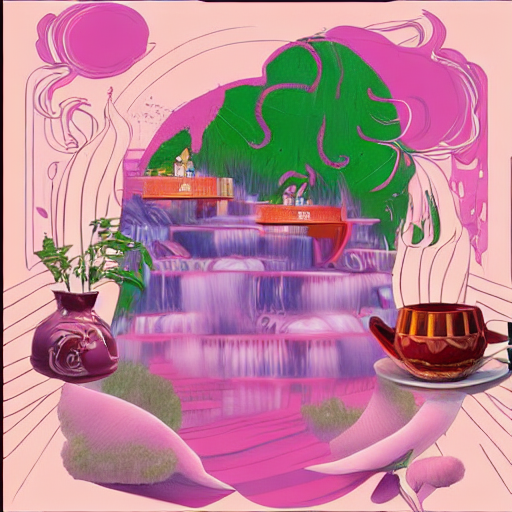

/content/drive/MyDrive/GLOO_SAMPLES/all_generated_outputs/default_80.jpg


In [ ]:
#@title Artwork Image Generation
#@markdown Re-run this cell to generate a new artwork image


final_prompt = prompt_select.value
print(final_prompt)
pipeline_output = pipe(final_prompt, width=512, height=512)
images = pipeline_output.images

image = images[0]

clear_output()
display(image)

save_image_file(image, prompt=final_prompt)